In [23]:
# TODO: これまでやってきた取り組みを遡ってスコア計測したい
# スコア計測して取り組みとスコアの推移を記録したら発表に使えるかも

In [24]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabelSequence, crf_label
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [26]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabelSequence.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabelSequence.from_abbreviation, data_test))

In [27]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [28]:
y_pred = model.predict(X_test)

In [29]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.7143050855446567

In [30]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] != crf_label.NG:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = (np.array(y_pred[i]) == y_test[i]).mean()
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

1.000 te re ho N ra bu -> te re ra bu
0.667 hi do ra ji Q do -> hi do
1.000 ri yu Q ku sa Q ku -> ri yu Q ku
0.625 ba ra e thi a i do ru -> ba ra a i do ru
1.000 do ro o bo o ru -> do ro o
0.286 a N gu ro a Q pu -> a N gu ro
0.250 o o to ma thi Q ku re vo ru va a -> o o to ma re vo ru va a
0.429 gu ru u pu cha Q to -> gu ru u pu
0.375 se Q ku su fu re N do -> se Q ku su
0.400 ba tsu thi N gu a be re e ji -> ba tsu a be
0.444 i ta ri a N ka ju a ru -> i ta ri a N
0.444 a ji te e to po i N to -> a ji po i N to
0.250 ro o gi a -> ro o gi a
1.000 ka Q to pu re e -> ka Q to
0.714 e ki su to ra ku to -> e ki su to
1.000 sho ru da a ba Q gu -> sho ru da a
1.000 ko ra bo re e sho N -> ko ra bo
1.000 ru u pu shu u to -> ru u pu
0.286 a gu ni mi sa i ru -> ni mi sa
1.000 fa a mu chi i mu -> fa a mu
1.000 bu ru se ra sho Q pu -> bu ru se ra
1.000 shi i ru su ki N -> shi i ru
0.600 de gu re e to -> de gu
1.000 ko N thi nyu i thi -> ko N
1.000 pu ri ma do N na -> pu ri ma
1.000 ba Q ku ga a do -> b

In [31]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.5196850393700787


In [32]:
score_list.mean()

0.7237015281306619

(array([ 22.,   3.,  12.,   9.,  17.,  22.,  20.,  16.,   1., 132.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

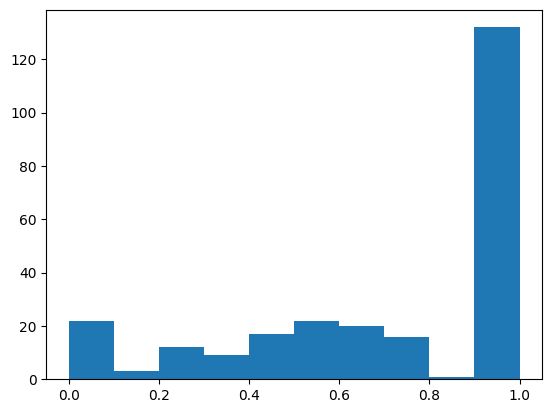

In [33]:
plt.hist(score_list, bins=10)